In [7]:
import pandas as pd
counts = pd.read_csv('/home/hsher/scratch/rar11_input.tsv', sep = '\t')
IN='PP_Input1'
IP='PP_Monosome1'

In [2]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
counts.head()

,Unnamed: 0,seqname,source,feature,start,end,strand,frame,circ_id,circ_type,...,BSJ-PP_Polysome1,BSJ-PP_Polysome2,BSJ-PP_Input2,BSJ-PP_Monosome1,FSJ-PP_Input1,FSJ-PP_Monosome2,FSJ-PP_Polysome1,FSJ-PP_Polysome2,FSJ-PP_Input2,FSJ-PP_Monosome1
0,0,chr1,CIRIquant,circRNA,746695.0,749381.0,-,.,chr1:746695|749381,intron,...,0.0,0.0,24.0,0.0,4.0,0.0,0.0,0.0,42.0,0.0
1,1,chr1,CIRIquant,circRNA,805799.0,810170.0,-,.,chr1:805799|810170,exon,...,0.0,9.0,34.0,11.0,8.0,0.0,0.0,3.0,16.0,1.0
2,2,chr1,CIRIquant,circRNA,915319.0,915949.0,+,.,chr1:915319|915949,intron,...,0.0,0.0,1.0,0.0,51.0,0.0,0.0,0.0,43.0,0.0
3,3,chr1,CIRIquant,circRNA,955923.0,957273.0,-,.,chr1:955923|957273,exon,...,0.0,0.0,2.0,0.0,222.0,15.0,0.0,0.0,220.0,0.0
4,4,chr1,CIRIquant,circRNA,1084353.0,1086012.0,-,.,chr1:1084353|1086012,exon,...,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0


In [4]:
counts.max()

/scratch/hsher/33384802.tscc-mgr7.local/ipykernel_33597/303668767.py:1: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  counts.max()


Unnamed: 0                           81919
seqname                               chrX
source                           CIRIquant
feature                            circRNA
start                          248916602.0
end                            248917961.0
strand                                   -
frame                                    .
circ_id             chrX:99653827|99660890
circ_type                           intron
BSJ-PP_Input1                      12465.0
BSJ-PP_Monosome2                    4761.0
BSJ-PP_Polysome1                     900.0
BSJ-PP_Polysome2                    2870.0
BSJ-PP_Input2                      11770.0
BSJ-PP_Monosome1                    9767.0
FSJ-PP_Input1                      38687.0
FSJ-PP_Monosome2                   86727.0
FSJ-PP_Polysome1                    1680.0
FSJ-PP_Polysome2                   14861.0
FSJ-PP_Input2                      36014.0
FSJ-PP_Monosome1                   53068.0
dtype: object

In [8]:
from itertools import combinations
import statsmodels.formula.api as smf
#https://stackoverflow.com/questions/46173061/statsmodels-throws-overflow-in-exp-and-divide-by-zero-in-log-warnings-and-ps
#extermely large numbers causing problems



y = f'BSJ-{IP}'
x = f'BSJ-{IN}'
sub_counts = counts

poisson_training_results = sm.GLM(sub_counts[y], np.log(sub_counts[x]+1), family=sm.families.Poisson()).fit()

# get lambda from Poisson
sub_counts['BB_LAMBDA'] = poisson_training_results.mu
sub_counts['AUX_OLS_DEP'] = sub_counts.apply(lambda row: ((row[y] - row['BB_LAMBDA'])**2 - row['BB_LAMBDA']) / row['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, sub_counts).fit()

# fit nb
nb2_training_results = sm.GLM(sub_counts[y], np.log(sub_counts[x]+1),
                              family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [9]:
aux_olsr_results.tvalues

BB_LAMBDA    89.444546
dtype: float64

In [10]:
aux_olsr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            AUX_OLS_DEP   R-squared (uncentered):                   0.060
Model:                            OLS   Adj. R-squared (uncentered):              0.060
Method:                 Least Squares   F-statistic:                              8000.
Date:                Thu, 21 Sep 2023   Prob (F-statistic):                        0.00
Time:                        10:11:39   Log-Likelihood:                     -9.7327e+05
No. Observations:              125726   AIC:                                  1.947e+06
Df Residuals:                  125725   BIC:                                  1.947e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
BB_LAMBDA     23.3685      0.261     89.445      0.000      22.856      23.881
==============================================================================
Omnibus:                   679003.655   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   42813603759912.297
Skew:                         285.005   Prob(JB):                         0.00
Kurtosis:                   90404.436   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(0.0, 100.0)

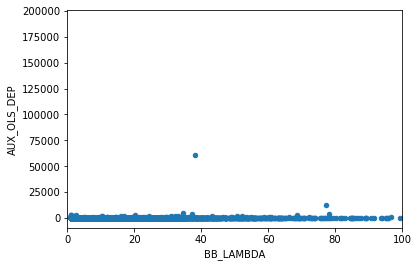

In [11]:
sub_counts.plot.scatter(y = 'AUX_OLS_DEP', x = 'BB_LAMBDA')
plt.xlim(0,100)

In [12]:
nb2_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       BSJ-PP_Monosome1   No. Observations:               125726
Model:                            GLM   Df Residuals:                   125725
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0427e+05
Date:                Thu, 21 Sep 2023   Deviance:                       34189.
Time:                        10:11:57   Pearson chi2:                 2.29e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.04907
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
BSJ-PP_Input1     0.3902      0.010     40.702      0.000       0.371       0.409
=================================================================================
"""

In [13]:
poisson_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       BSJ-PP_Monosome1   No. Observations:               125726
Model:                            GLM   Df Residuals:                   125725
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.6024e+05
Date:                Thu, 21 Sep 2023   Deviance:                   6.5920e+05
Time:                        10:11:59   Pearson chi2:                 8.88e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9922
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
BSJ-PP_Input1     0.6488      0.001   1180.626      0.000       0.648       0.650
=================================================================================
"""

In [57]:
# for (rep1, rep2) in combinations(replicates,2):
#     y = f'BSJ-{rep1}'
#     x = [f'BSJ-{rep2}', f'FSJ-{rep1}', f'FSJ-{rep2}']
    
#     poisson_training_results_2 = sm.GLM(counts[y], counts[x], family=sm.families.Poisson()).fit()

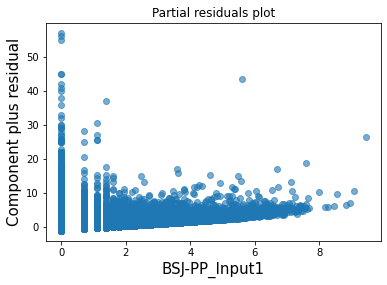

In [14]:
f = poisson_training_results.plot_partial_residuals(x)

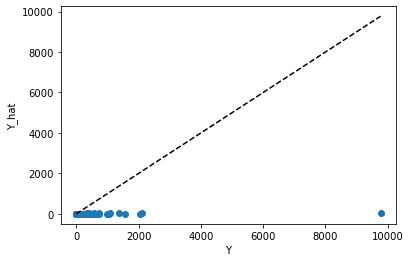

In [15]:
plt.scatter(counts[y], nb2_training_results.predict(np.log(counts[x]+1)),)
plt.xlabel('Y')
plt.ylabel('Y_hat')
plt.plot([0, counts[y].max()], [0, counts[y].max()], '--', color = 'black')

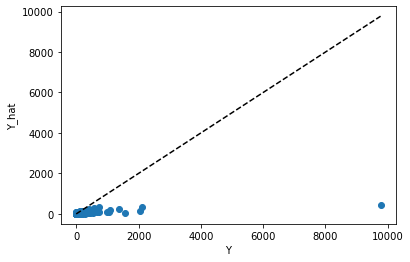

In [16]:
plt.scatter(counts[y], poisson_training_results.predict(np.log(counts[x]+1)))
plt.xlabel('Y')
plt.ylabel('Y_hat')
plt.plot([0, counts[y].max()], [0, counts[y].max()], '--', color = 'black')

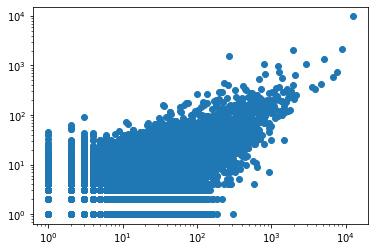

In [17]:
plt.scatter(counts[x], counts[y])
plt.xscale('log')
plt.yscale('log')

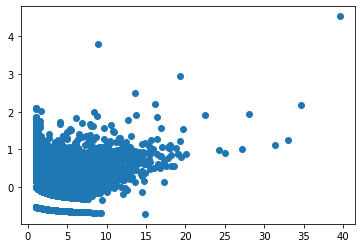

In [18]:
plt.scatter(nb2_training_results.fittedvalues, nb2_training_results.resid_deviance)

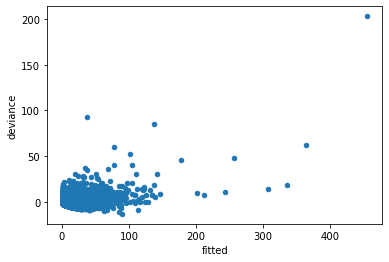

In [19]:
dev = pd.DataFrame([poisson_training_results.fittedvalues, poisson_training_results.resid_deviance],
                  index = ['fitted', 'deviance']).T
dev.plot.scatter(x = f'fitted', y = 'deviance')
dev = pd.concat([dev, sub_counts], axis = 1)

In [22]:
from scipy.stats import poisson
sub_counts['pvalue']=sub_counts.apply(lambda row: 1-poisson(row['BB_LAMBDA']).cdf(row[f'BSJ-{IP}']), axis = 1)


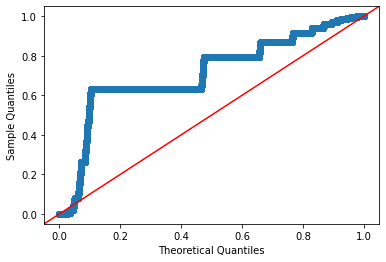

In [24]:
import scipy
p = sm.qqplot(sub_counts['pvalue'], line ='45',
             dist=scipy.stats.uniform)